In [1]:
import neurokit2 as nk
from scipy import signal, stats

from scipy.signal import find_peaks, savgol_filter
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# import neurokit2 as nk
from tqdm import tqdm
import pandas as pd
import numpy as np
import umap
import h5py

import torch.optim as optim
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
device='cpu'

In [3]:
class AttentionLayer(nn.Module):
    """Механизм внимания для временных рядов."""
    def __init__(self, hidden_dim):
        super().__init__()
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        # x: (batch, seq_len, hidden_dim)
        Q = self.query(x)
        K = self.key(x)
        scores = torch.matmul(Q, K.transpose(1, 2)) / torch.sqrt(torch.tensor(x.shape[-1]))
        weights = torch.softmax(scores, dim=-1)
        return torch.matmul(weights, x)

class ECGEncoder(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(64, hidden_dim, batch_first=True)
        self.attention = AttentionLayer(hidden_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, 1, seq_len) -> (batch, channels, seq_len)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.permute(0, 2, 1)  # (batch, seq_len, channels)
        x, _ = self.lstm(x)
        x = self.attention(x)
        return x

class ECGDecoder(nn.Module):
    def __init__(self, hidden_dim=64, output_dim=1):
        super().__init__()
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.upconv1 = nn.ConvTranspose1d(
            hidden_dim, 32, 
            kernel_size=3, 
            stride=2,
            output_padding=1
        )
        self.upconv2 = nn.ConvTranspose1d(
            32, output_dim, 
            kernel_size=5, 
            stride=2,
            padding=2,
            output_padding=1
        )
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x.permute(0, 2, 1)
        x = torch.relu(self.upconv1(x))
        # x = torch.tanh(self.upconv2(x))  # <- tanh вместо sigmoid
        x = self.upconv2(x)
        return x.permute(0, 2, 1)[:, :5000, :]

class ECGAutoencoder(nn.Module):
    def __init__(self, input_channels=1):
        super().__init__()
        self.encoder = ECGEncoder(input_dim=input_channels)
        self.decoder = ECGDecoder(output_dim=input_channels)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def get_embeddings(self, x):
        with torch.no_grad():
            return self.encoder(x)

In [4]:
def ultra_filter(signals, n=None, channel=None):
    if n == None and channel==None:
        y = signals
    else:
        y = signals[n][channel]

    # 1. Найдем пики
    peaks, _ = find_peaks(y, height=(0.1, 0.5), distance=10)
    peaks = peaks[peaks < len(y)]

    # 2. Найдем тренд с помощью фильтра Савицкого-Голея
    y_trend = savgol_filter(y, window_length=51, polyorder=3)

    # 3. Удалим тренд, чтобы получить колебания (пики и волны)
    y_fluctuations = y - y_trend

    # 4. Обработаем волны (сгладим их)
    y_waves_smoothed = savgol_filter(y_fluctuations, window_length=21, polyorder=2)

    # 5. Восстановим данные, добавив колебания к тренду
    y_restored = y_trend + y_waves_smoothed

    return y_restored

def signal_transform_tensor_1(signals, N=0, max_len_signal=5000, sampling_rate=500):
    """Транформирует сигналы в тензор.\n
    N - номер отведения в соответствии с массивом:\n
    ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']"""

    # Ограничиваем максимальную длину до единого значения для использования в батче.
    # Дописывать нули в конце для одной длины - сомнительная идея для LSTM.

    i = 0

    result_reshape = np.reshape([ultra_filter([float(ss) for ss in signal[i][0:max_len_signal]]) for signal in signals], (1, max_len_signal * len(signals)))
    # result_reshape = np.reshape([[float(ss) for ss in signal[i][0:max_len_signal]] for signal in signals], (1, max_len_signal * len(signals)))

    return torch.tensor(result_reshape, dtype=torch.float32).reshape((1, len(signals), max_len_signal)).permute((1,2,0))

def label_transform_tensor(labels, all_diagnoses=False):
    """Транформирует лейблы в тензор.\n
    Сейчас только в режиме 'Норма-Не норма'."""

    # TODO: сделать разбиение лейблов на первичное и вторичное заключение врача

    result_labels = []

    if all_diagnoses:
        return None
    
    else:
        # Норма - Не норма
        for label in labels:
            if label == '1':
                result_labels.append(0)
            else:
                result_labels.append(1)

    result_labels = torch.tensor(result_labels, dtype=torch.float32).reshape((len(result_labels), 1))

    print("Label transformed to tensor successfully\n")

    return result_labels

In [5]:
def ecg_quality_metrics(signal, fs=1000):
    # Очистка сигнала
    cleaned = nk.ecg_clean(signal, sampling_rate=fs)
    
    # Детекция R-пиков
    r_peaks = nk.ecg_findpeaks(cleaned, sampling_rate=fs)['ECG_R_Peaks']
    
    # Расчет SNR
    noise = signal - cleaned
    snr = 10 * np.log10(np.var(cleaned) / np.var(noise))
    
    # Стабильность RR-интервалов
    rr = np.diff(r_peaks) / fs * 1000  # в мс
    cv_rr = (np.std(rr) / np.mean(rr)) * 100  # Коэффициент вариации
    
    # return {"SNR_dB": snr, "RR_CV%": cv_rr}
    return snr, cv_rr

def ecg_quality_metrics_ultra(signal, fs=1000):
    # Очистка сигнала
    cleaned = ultra_filter(signal)
    
    # Детекция R-пиков
    r_peaks = nk.ecg_findpeaks(cleaned, sampling_rate=fs)['ECG_R_Peaks']
    
    # Расчет SNR
    noise = signal - cleaned
    snr = 10 * np.log10(np.var(cleaned) / np.var(noise))
    
    # Стабильность RR-интервалов
    rr = np.diff(r_peaks) / fs * 1000  # в мс
    cv_rr = (np.std(rr) / np.mean(rr)) * 100  # Коэффициент вариации
    
    # return {"SNR_dB": snr, "RR_CV%": cv_rr}
    return snr, cv_rr

In [6]:
def load_data(metadata_filepath='metadata.csv', N_start=0, N_end=10, only_health=False):
    """Загрузка данных из файлов.\n
    Работает только при наличии директории 'records',\n
    в которой пять папок по 5000 файлов записей"""
    
    # Загружаем метаданные и выбираем срезом нужные
    metadata_full = pd.read_csv(metadata_filepath)
    metadata = metadata_full.iloc[N_start:N_end]

    # Убираем лишние столбцы, приводим к типу int32
    metadata = metadata.drop(columns=['Date', 'Patient_ID'])
    metadata['Age'].astype(np.int32)
    metadata['N'].astype(np.int32)

    if only_health:
        # Берём только здоровых людей
        health_metadata = metadata.loc[metadata['AHA_Code'] == '1']
        id_metadata = health_metadata['ECG_ID'].values
        labels = health_metadata['AHA_Code'].values
    else:
        # Берём всех
        id_metadata = metadata['ECG_ID'].values
        labels = metadata['AHA_Code'].values

    signals = []

    for i in id_metadata:
        # Из Axxxxx оставляем численную часть
        number = int(i[1:])

        # В каждой папке 5000 файлов (кроме пятой), поэтому,
        # чтобы узнать номер папки, в которой запись, делим на 5000
        record_num = (number - 1) // 5000
        if record_num > 4:
            record_num = 4
        record_num = record_num + 1
        
        # Считываем файл.
        if record_num == 1:
            file_name_ = f'../records/record{record_num}/{i}.h5'
        else:
            file_name_ = f'../records/records{record_num}/{i}.h5'
        with h5py.File(file_name_, 'r') as f:
            signals.append(f['ecg'][()])
    
    health_n = len(labels[labels == '1'])
    diseased_n = len(labels[labels != '1'])

    print(f"Data loaded successfully.\n\
          Health    number:     {health_n}\n\
          Diseased  number:     {diseased_n}\n\n")

    return signals, labels

def load_data_age_sex(metadata_filepath='metadata.csv', N_start=0, N_end=10, only_health=False):
    """Загрузка данных из файлов.\n
    Работает только при наличии директории 'records',\n
    в которой пять папок по 5000 файлов записей"""
    
    # Загружаем метаданные и выбираем срезом нужные
    metadata_full = pd.read_csv(metadata_filepath)
    metadata = metadata_full.iloc[N_start:N_end]

    # Убираем лишние столбцы, приводим к типу int32
    metadata = metadata.drop(columns=['Date', 'Patient_ID'])
    metadata['Age'].astype(np.int32)
    metadata['N'].astype(np.int32)

    metadata['Sex'].replace({'M': 0, 'F': 1}, inplace=True)

    if only_health:
        # Берём только здоровых людей
        health_metadata = metadata.loc[metadata['AHA_Code'] == '1']
        id_metadata = health_metadata['ECG_ID'].values
        labels = health_metadata['AHA_Code'].values
        ages = health_metadata['Age'].values
        sexs = health_metadata['Sex'].values
    else:
        # Берём всех
        id_metadata = metadata['ECG_ID'].values
        labels = metadata['AHA_Code'].values
        ages = metadata['Age'].values
        sexs = metadata['Sex'].values

    signals = []

    for i in id_metadata:
        # Из Axxxxx оставляем численную часть
        number = int(i[1:])

        # В каждой папке 5000 файлов (кроме пятой), поэтому,
        # чтобы узнать номер папки, в которой запись, делим на 5000
        record_num = (number - 1) // 5000
        if record_num > 4:
            record_num = 4
        record_num = record_num + 1
        
        # Считываем файл.
        if record_num == 1:
            file_name_ = f'../records/record{record_num}/{i}.h5'
        else:
            file_name_ = f'../records/records{record_num}/{i}.h5'
        with h5py.File(file_name_, 'r') as f:
            signals.append(f['ecg'][()])
    
    health_n = len(labels[labels == '1'])
    diseased_n = len(labels[labels != '1'])

    print(f"Data loaded successfully.\n\
          Health    number:     {health_n}\n\
          Diseased  number:     {diseased_n}\n\n")

    return signals, labels, ages, sexs

In [7]:
def delete_bad_snr_db(signals_, labels_, channel_check=0, print_idx=False):
    signals = []
    labels = []
    deleted_idx = []
    
    for i in range(len(signals_)):
        sbr_db, rr = ecg_quality_metrics_ultra(signals_[i][channel_check], 500)
        
        if sbr_db >= 15:
            signals.append(signals_[i])
            labels.append(labels_[i])
        else:
            deleted_idx.append(i)
    
    if print_idx:
        print("deleted indexes:")
        print(*deleted_idx)
    
    print(f"num of left: {len(signals)}")
    
    return signals, labels

def delete_bad_snr_db_ages_sexs(signals_, labels_, ages_=None, sexs_=None, channel_check=0, print_idx=False):
    signals = []
    labels = []
    ages = []
    sexs = []
    deleted_idx = []
    
    for i in range(len(signals_)):
        sbr_db, rr = ecg_quality_metrics_ultra(signals_[i][channel_check], 500)
        
        if sbr_db >= 15:
            signals.append(signals_[i])
            labels.append(labels_[i])
            ages.append(ages_[i])
            sexs.append(sexs_[i])
        else:
            deleted_idx.append(i)
    
    if print_idx:
        print("deleted indexes:")
        print(*deleted_idx)
    
    print(f"num of left: {len(signals)}")
    
    return signals, labels, ages, sexs

In [9]:
signals, labels = load_data('../csv/metadata.csv', 0, 10, False)

signals_transformed = signal_transform_tensor_1(signals)
labels_transformed = label_transform_tensor(labels)

Data loaded successfully.
          Health    number:     6
          Diseased  number:     4


Label transformed to tensor successfully



In [10]:
for signal in signals:
    print(ecg_quality_metrics(signal[0], 500), ecg_quality_metrics_ultra(signal[0], 500))

(6.614577477278037, 5.471040213370633) (12.644857755094744, 5.471040213370633)
(11.338293101809116, 3.2144348115207775) (19.713062329526206, 3.2144348115207775)
(3.295745632312128, 1.9351897998363672) (6.279194385754549, 1.9016109317114938)
(7.155461442823588, 6.025592569299811) (13.944541860250308, 6.006323942180435)
(12.685352026744315, 2.6797482588627233) (18.62831616767306, 2.6797482588627233)
(8.597129164412355, 2.1123952958402588) (13.657342668324041, 2.1351343288029483)
(11.888090212708136, 2.4296799553489383) (19.593207923600865, 2.452081889567656)
(12.070263563129949, 7.324283917627544) (18.751030461422037, 7.324283917627544)
(10.987367076138234, 1.4980763264326358) (19.07906176658788, 1.4980763264326358)
(11.445344885024245, 2.516144041911693) (20.069178130366335, 2.516144041911693)


Удивительно (и приятно), но ultra_filter работает лучше, чем nk.ecg_clean, судя по значениям SNR_dB (высокие значения означают высокую смысловую нагрузку)

In [11]:
signals, labels = load_data('../csv/metadata.csv', 0, 1000, False)
signals, labels = delete_bad_snr_db(signals, labels)

signals_transformed = signal_transform_tensor_1(signals)
labels_transformed = label_transform_tensor(labels)

# window_size = 800
# stride = window_size - 100
# X = split_into_windows(signals_transformed, window_size=window_size, stride=stride)
# X.shape

# scaler = StandardScaler()
# X = scaler.fit_transform(X.reshape(-1, 1)).reshape(-1, window_size, 1)

# y = []
# for i in labels_transformed:
#     for k in range(7):
#         y.append(i.detach().numpy().tolist())

# y = torch.tensor(y, dtype=torch.float32).reshape((len(y), 1))

X = torch.tensor(signals_transformed)
y = torch.tensor(labels_transformed, dtype=torch.float32).reshape((len(labels_transformed), 1))

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Конвертация в тензоры
train_data = torch.FloatTensor(X_train).to(device)
test_data = torch.FloatTensor(X_test).to(device)

train_loader = DataLoader(TensorDataset(train_data, train_data), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(test_data, test_data), batch_size=32)

Data loaded successfully.
          Health    number:     515
          Diseased  number:     485


num of left: 734
Label transformed to tensor successfully



In [12]:
model = ECGAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

def train_model(epochs=50):
    best_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            x, _ = batch
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, x)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Валидация
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                x, _ = batch
                output = model(x)
                val_loss += criterion(output, x).item()
        
        avg_val_loss = val_loss / len(test_loader)
        scheduler.step(avg_val_loss)
        
        # Ранняя остановка
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), "./best_model.pth")
        
        print(f"Epoch {epoch+1}: Train Loss = {train_loss/len(train_loader):.4f}, Val Loss = {avg_val_loss:.4f}")

train_model(epochs=1)

Epoch 1: 100%|██████████| 19/19 [00:22<00:00,  1.20s/it]


Epoch 1: Train Loss = 0.0239, Val Loss = 0.0102


In [24]:
def umaper(model, x_data, y_data, n_components=2, alpha=0.3):
    model.eval()

    with torch.no_grad():
        embeddings = model.get_embeddings(x_data).numpy()
    
    embeddings_avg = embeddings.mean(axis=1)
    reducer = umap.UMAP(n_components=n_components)
    embeddings_2d = reducer.fit_transform(embeddings_avg)

    num = [331, 332, 333, 334, 335, 336, 337, 338, 339]
    k = 0

    print("UMAP, average")
    for i in range(n_components):
        for j in range(i, n_components):
            if k >= 9:
                k = 0
                plt.show()
                plt.figure()
            plt.subplot(num[k])

            plt.scatter(
                embeddings_2d[:, i], 
                embeddings_2d[:, j],
                c=y_data,  # Цвета по y_data
                cmap="viridis",
                alpha=alpha
            )
            plt.xlabel(f"feature_{i}")
            plt.ylabel(f"feature_{j}")
            k += 1
    
    if k != 9:
        plt.show()
    
    k = 0

    embeddings_flatten = embeddings.reshape(embeddings.shape[0], -1)

    reducer = umap.UMAP(n_components=n_components)
    embeddings_2d = reducer.fit_transform(embeddings_flatten)

    print("UMAP, flatten")
    for i in range(n_components):
        for j in range(i, n_components):
            if k >= 9:
                k = 0
                plt.show()
                plt.figure()
            plt.subplot(num[k])

            plt.scatter(
                embeddings_2d[:, i], 
                embeddings_2d[:, j],
                c=y_data,  # Цвета по y_data
                cmap="viridis",
                alpha=alpha
            )
            plt.xlabel(f"feature_{i}")
            plt.ylabel(f"feature_{j}")
            k += 1

UMAP, average


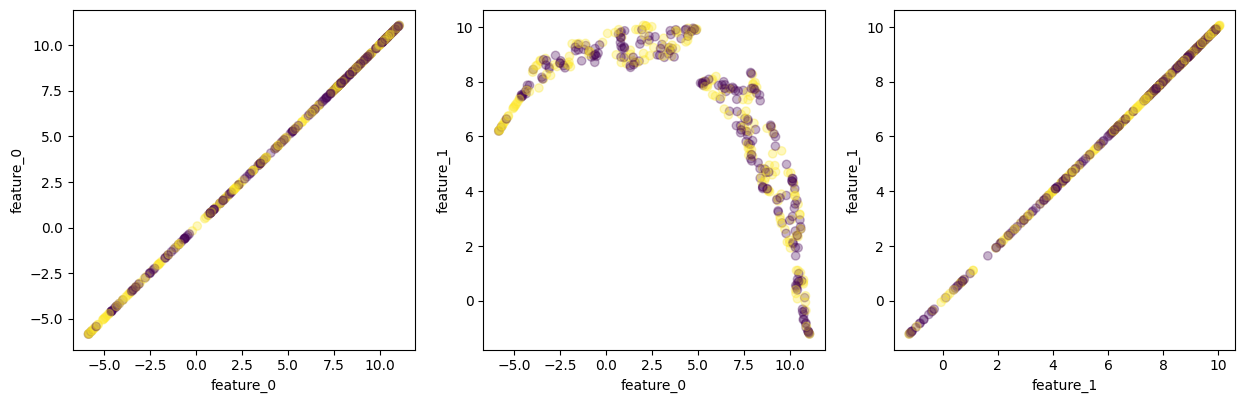

UMAP, flatten


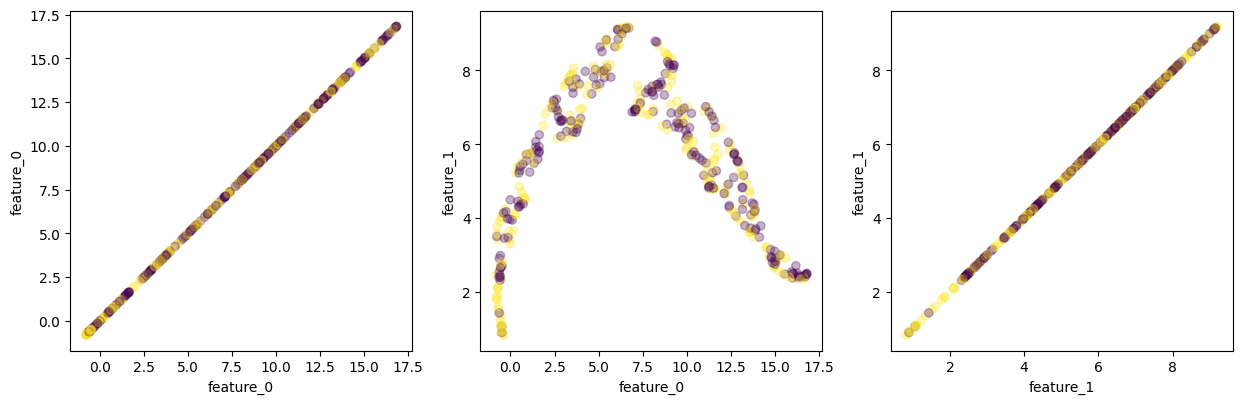

In [14]:
n = 400
X_2 = X[0:n]
y_2 = y[0:n]

plt.rcParams['figure.figsize'] = [15, 15]

umaper(model, X_2, y_2)

UMAP, average


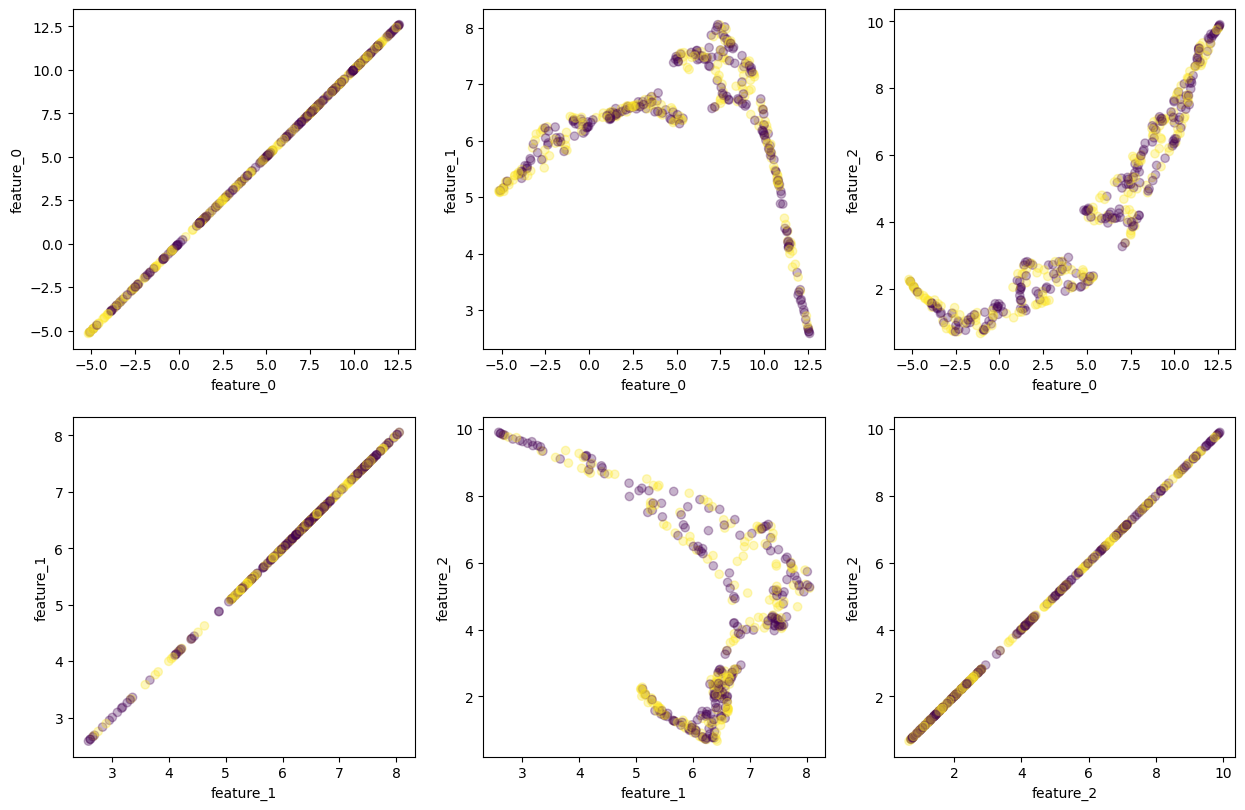

UMAP, flatten


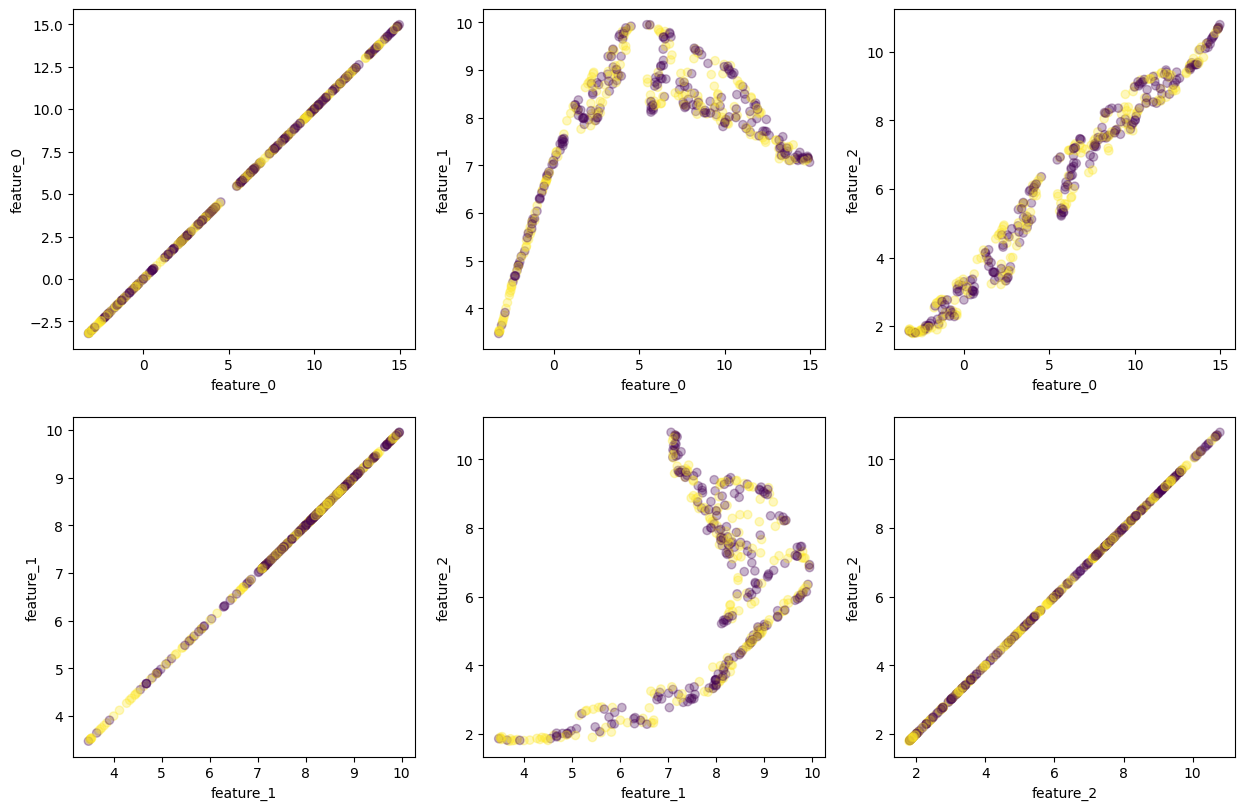

In [15]:
n = 400
X_2 = X[0:n]
y_2 = y[0:n]

plt.rcParams['figure.figsize'] = [15, 15]

umaper(model, X_2, y_2, n_components=3)

In [53]:
def signal_transform_tensor_12(signals, N=0, max_len_signal=5000, sampling_rate=500):
    """Транформирует сигналы в тензор.\n
    N - номер отведения в соответствии с массивом:\n
    ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']"""

    # Ограничиваем максимальную длину до единого значения для использования в батче.
    # Дописывать нули в конце для одной длины - сомнительная идея для LSTM.

    # i = 0

    # s = [normalize_relative_to_II([[float(ss) for ss in signal[i][0:max_len_signal]] for i in range(12)]) for signal in signals]
    s = [[[float(ss) for ss in signal[i][0:max_len_signal]] for i in range(12)] for signal in signals]

    k = np.reshape(s, (1, max_len_signal * len(signals) * 12))

    # print(k.shape)

    h = torch.tensor(k, dtype=torch.float32).reshape((12, len(signals), max_len_signal)).permute((1,2,0))

    return h

    # print(h.shape)

    # # result_reshape = np.reshape([ultra_filter([float(ss) for ss in signal[i][0:max_len_signal]]) for signal in signals], (1, max_len_signal * len(signals)))
    # result_reshape = np.reshape([[float(ss) for ss in signal[i][0:max_len_signal]] for signal in signals], (1, max_len_signal * len(signals)))

    # return torch.tensor(result_reshape, dtype=torch.float32).reshape((1, len(signals), max_len_signal)).permute((1,2,0))

In [70]:
signals, labels = load_data('../csv/metadata.csv', 0, 200, False)
signals, labels = delete_bad_snr_db(signals, labels)

signals_transformed = signal_transform_tensor_12(signals)
labels_transformed = label_transform_tensor(labels)

global_mean = []
global_std = []
for i in range(12):
    global_mean.append([])
    global_std.append([])

for signal in signals_transformed:
    for i in range(12):
        global_mean[i] = global_mean[i] + signal[i].mean().numpy()
        global_std[i] = global_std[i] + signal[i].std().numpy()

global_mean = np.array(global_mean) / len(signals_transformed)
global_std = np.array(global_std) / len(signals_transformed)

X = torch.tensor(signals_transformed)
y = torch.tensor(labels_transformed, dtype=torch.float32).reshape((len(labels_transformed), 1))

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Конвертация в тензоры
train_data = torch.FloatTensor(X_train).to(device)
test_data = torch.FloatTensor(X_test).to(device)

train_loader = DataLoader(TensorDataset(train_data, train_data), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(test_data, test_data), batch_size=32)

Data loaded successfully.
          Health    number:     108
          Diseased  number:     92


num of left: 141
Label transformed to tensor successfully



In [71]:
model = ECGAutoencoder(12).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

def train_model(epochs=50):
    best_loss = float('inf')
    
    # 1. Индивидуальные лоссы для каждого отведения
    criterion_per_channel = nn.MSELoss(reduction='none')  # Возвращает loss для каждого элемента
    
    # 2. Веса для отведений (например, больше веса для II, V5)
    channel_weights = torch.tensor([1.0, 1.2, 1.0, 1.0, 1.0, 1.0, 1.1, 1.1, 1.0, 1.2, 1.3, 1.2]).to(device)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            x, _ = batch  # x: (batch, seq_len, 12)
            x = x.to(device)
            
            optimizer.zero_grad()
            output = model(x)
            
            # 3. Расчет взвешенного лосса
            loss_per_channel = criterion_per_channel(output, x).mean(dim=[0,1])  # (12,)
            weighted_loss = (loss_per_channel * channel_weights).mean()  # Скаляр
            
            weighted_loss.backward()
            optimizer.step()
            train_loss += weighted_loss.item()
        
        # Валидация (аналогично, но без весов)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                x, _ = batch
                x = x.to(device)
                output = model(x)
                val_loss += criterion_per_channel(output, x).mean().item()  # Общий лосс
        
        avg_val_loss = val_loss / len(test_loader)
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), "./best_model.pth")
        
        print(f"Epoch {epoch+1}: Train Loss = {train_loss/len(train_loader):.4f}, Val Loss = {avg_val_loss:.4f}")
        print(f"Loss per channel: {loss_per_channel.detach().cpu().numpy().round(4)}")  # Мониторинг

train_model(epochs=10)

Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


Epoch 1: Train Loss = 0.0440, Val Loss = 0.0427
Loss per channel: [0.05   0.0502 0.0165 0.033  0.0353 0.0363 0.024  0.0399 0.0382 0.0349
 0.0228 0.0396]


Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Epoch 2: Train Loss = 0.0429, Val Loss = 0.0418
Loss per channel: [0.031  0.1041 0.0316 0.0225 0.0275 0.0402 0.0302 0.0307 0.0215 0.0426
 0.0226 0.0293]


Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Epoch 3: Train Loss = 0.0431, Val Loss = 0.0413
Loss per channel: [0.0369 0.0266 0.0315 0.0409 0.0253 0.0428 0.0285 0.1727 0.0257 0.0191
 0.0313 0.0373]


Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Epoch 4: Train Loss = 0.0424, Val Loss = 0.0410
Loss per channel: [0.0558 0.0732 0.026  0.038  0.0486 0.0442 0.0324 0.0405 0.0408 0.0256
 0.028  0.0368]


Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 5: Train Loss = 0.0422, Val Loss = 0.0408
Loss per channel: [0.041  0.1034 0.0235 0.0432 0.0332 0.0279 0.027  0.0356 0.0341 0.0456
 0.038  0.0284]


Epoch 6: 100%|██████████| 4/4 [00:04<00:00,  1.25s/it]


Epoch 6: Train Loss = 0.0409, Val Loss = 0.0408
Loss per channel: [0.0337 0.0318 0.0274 0.0262 0.0268 0.0438 0.0402 0.0388 0.0335 0.0304
 0.027  0.0298]


Epoch 7: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Epoch 7: Train Loss = 0.0434, Val Loss = 0.0407
Loss per channel: [0.0612 0.1704 0.0208 0.0225 0.0398 0.0581 0.0197 0.04   0.0532 0.0436
 0.0371 0.0338]


Epoch 8: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Epoch 8: Train Loss = 0.0424, Val Loss = 0.0407
Loss per channel: [0.0349 0.0142 0.0203 0.0362 0.0353 0.0344 0.0297 0.1929 0.0402 0.02
 0.0206 0.0447]


Epoch 9: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Epoch 9: Train Loss = 0.0432, Val Loss = 0.0407
Loss per channel: [0.0406 0.1938 0.0455 0.035  0.0227 0.0154 0.0531 0.0405 0.0332 0.0284
 0.0368 0.0331]


Epoch 10: 100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


Epoch 10: Train Loss = 0.0415, Val Loss = 0.0407
Loss per channel: [0.0413 0.0737 0.0353 0.026  0.048  0.0246 0.0347 0.0331 0.0306 0.0327
 0.0293 0.0316]


In [84]:
signals, labels = load_data('../csv/metadata.csv', 0, 200, False)
signals, labels = delete_bad_snr_db(signals, labels)

signals_transformed = signal_transform_tensor_12(signals)
labels_transformed = label_transform_tensor(labels)

global_mean = []
global_std = []
for i in range(12):
    global_mean.append(0)
    global_std.append(0)

for signal in signals_transformed:
    for i in range(12):
        global_mean[i] = global_mean[i] + signal[i].mean().numpy()
        global_std[i] = global_std[i] + signal[i].std().numpy()

global_mean = np.array(global_mean) / len(signals_transformed)
global_std = np.array(global_std) / len(signals_transformed)

X = torch.tensor(signals_transformed, dtype=torch.float32)
y = torch.tensor(labels_transformed, dtype=torch.float32).reshape((len(labels_transformed), 1))

X = (X - global_mean) / (global_std + 1e-8)

X = torch.tensor(X, dtype=torch.float32)

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Конвертация в тензоры
train_data = torch.FloatTensor(X_train).to(device)
test_data = torch.FloatTensor(X_test).to(device)

train_loader = DataLoader(TensorDataset(train_data, train_data), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(test_data, test_data), batch_size=32)

Data loaded successfully.
          Health    number:     108
          Diseased  number:     92


num of left: 141
Label transformed to tensor successfully



In [85]:
model = ECGAutoencoder(12).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

train_model(epochs=10)

Epoch 1: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]


Epoch 1: Train Loss = 1.6126, Val Loss = 1.5251
Loss per channel: [1.2738 7.8494 1.1643 0.9842 0.8646 1.8988 1.243  0.6823 1.0845 1.6573
 0.9524 0.6722]


Epoch 2: 100%|██████████| 4/4 [00:06<00:00,  1.70s/it]


Epoch 2: Train Loss = 1.6395, Val Loss = 1.5239
Loss per channel: [1.9696 9.2142 0.9698 1.289  1.3276 1.2712 1.1332 1.3029 1.1565 1.5051
 0.6172 1.077 ]


Epoch 3: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Epoch 3: Train Loss = 1.5987, Val Loss = 1.5233
Loss per channel: [0.9222 2.6841 0.7074 1.2242 1.038  2.1186 1.3024 6.5049 1.1139 0.6375
 0.8232 0.8634]


Epoch 4: 100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Epoch 4: Train Loss = 1.5358, Val Loss = 1.5228
Loss per channel: [1.811  1.3252 1.2257 0.7178 0.9961 1.4747 1.3486 1.0277 1.1296 1.0362
 1.6705 0.7218]


Epoch 5: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Epoch 5: Train Loss = 1.5363, Val Loss = 1.5225
Loss per channel: [1.1339 1.4763 1.0683 0.7962 1.585  1.7697 2.1498 1.1407 1.0425 0.9682
 0.7254 0.8651]


Epoch 6: 100%|██████████| 4/4 [00:05<00:00,  1.27s/it]


Epoch 6: Train Loss = 1.5816, Val Loss = 1.5223
Loss per channel: [0.7186 1.44   1.2038 0.8152 0.9075 1.358  1.5497 6.1273 0.8439 1.2536
 1.5707 0.6245]


Epoch 7: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


Epoch 7: Train Loss = 1.5432, Val Loss = 1.5221
Loss per channel: [1.924  0.9677 1.3382 1.4801 1.2073 0.8876 1.3824 1.4585 1.093  0.9249
 1.6136 1.0265]


Epoch 8: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Epoch 8: Train Loss = 1.5670, Val Loss = 1.5220
Loss per channel: [1.6936 1.9041 1.7341 0.9954 1.2343 3.0816 1.4366 0.8739 1.2698 1.3053
 1.2751 0.7439]


Epoch 9: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


Epoch 9: Train Loss = 1.5289, Val Loss = 1.5218
Loss per channel: [1.0633 1.3253 0.8063 1.5452 1.6806 1.0962 1.135  1.2506 0.9127 1.3304
 1.0131 0.9051]


Epoch 10: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 10: Train Loss = 1.6120, Val Loss = 1.5204
Loss per channel: [1.2871 6.9711 1.1305 1.1709 1.2983 2.7707 1.2202 1.4661 1.2795 0.9399
 0.6581 0.9252]


In [ ]:
signals, labels = load_data('../csv/metadata.csv', 0, 20, False)
signals, labels = delete_bad_snr_db(signals, labels)

signals_transformed = signal_transform_tensor_12(signals)
labels_transformed = label_transform_tensor(labels)

X = torch.tensor(signals_transformed)
y = torch.tensor(labels_transformed, dtype=torch.float32).reshape((len(labels_transformed), 1))

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Конвертация в тензоры
train_data = torch.FloatTensor(X_train).to(device)
test_data = torch.FloatTensor(X_test).to(device)

train_loader = DataLoader(TensorDataset(train_data, train_data), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(test_data, test_data), batch_size=32)

Data loaded successfully.
          Health    number:     11
          Diseased  number:     9


num of left: 14
Label transformed to tensor successfully



In [34]:
def normalize_relative_to_II(x):
    scale_factor = np.std(x[1])  # II отведение (индекс 1)
    return x / (scale_factor + 1e-8)

In [36]:
model = ECGAutoencoder(12).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

def train_model(epochs=50):
    best_loss = float('inf')
    
    # 1. Индивидуальные лоссы для каждого отведения
    criterion_per_channel = nn.MSELoss(reduction='none')  # Возвращает loss для каждого элемента
    
    # 2. Веса для отведений (например, больше веса для II, V5)
    channel_weights = torch.tensor([1.0, 1.2, 1.0, 1.0, 1.0, 1.0, 1.1, 1.1, 1.0, 1.2, 1.3, 1.2]).to(device)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            x, _ = batch  # x: (batch, seq_len, 12)
            x = x.to(device)
            
            optimizer.zero_grad()
            output = model(x)
            
            # 3. Расчет взвешенного лосса
            loss_per_channel = criterion_per_channel(output, x).mean(dim=[0,1])  # (12,)
            weighted_loss = (loss_per_channel * channel_weights).mean()  # Скаляр
            
            weighted_loss.backward()
            optimizer.step()
            train_loss += weighted_loss.item()
        
        # Валидация (аналогично, но без весов)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                x, _ = batch
                x = x.to(device)
                output = model(x)
                val_loss += criterion_per_channel(output, x).mean().item()  # Общий лосс
        
        avg_val_loss = val_loss / len(test_loader)
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), "./best_model.pth")
        
        print(f"Epoch {epoch+1}: Train Loss = {train_loss/len(train_loader):.4f}, Val Loss = {avg_val_loss:.4f}")
        print(f"Loss per channel: {loss_per_channel.detach().cpu().numpy().round(4)}")  # Мониторинг

train_model(epochs=10)

Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Epoch 1: Train Loss = 3.8293, Val Loss = 2.7167
Loss per channel: [ 2.0425 12.3893  4.8474  2.4431  1.4161  1.1069  3.1053  4.3188  2.0941
  3.6793  2.3749  1.2211]


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch 2: Train Loss = 3.8281, Val Loss = 2.7158
Loss per channel: [ 2.0418 12.3879  4.8473  2.4425  1.4145  1.1057  3.1052  4.3179  2.0915
  3.6784  2.3741  1.2195]


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Epoch 3: Train Loss = 3.8272, Val Loss = 2.7150
Loss per channel: [ 2.0413 12.3869  4.8473  2.4417  1.4129  1.1043  3.1051  4.3171  2.0893
  3.6778  2.3735  1.2182]


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Epoch 4: Train Loss = 3.8264, Val Loss = 2.7143
Loss per channel: [ 2.0408 12.3862  4.8473  2.4409  1.4114  1.1028  3.105   4.3164  2.0874
  3.6775  2.3732  1.2174]


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


Epoch 5: Train Loss = 3.8256, Val Loss = 2.7137
Loss per channel: [ 2.0403 12.3857  4.8472  2.44    1.4098  1.1013  3.1048  4.3157  2.0857
  3.6773  2.3729  1.2168]


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch 6: Train Loss = 3.8250, Val Loss = 2.7132
Loss per channel: [ 2.04   12.3854  4.8471  2.4388  1.4082  1.1     3.1046  4.3152  2.0843
  3.6772  2.3728  1.2164]


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Epoch 7: Train Loss = 3.8244, Val Loss = 2.7127
Loss per channel: [ 2.0397 12.3856  4.8472  2.4376  1.4067  1.0988  3.1042  4.3146  2.0834
  3.677   2.3727  1.2162]


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


Epoch 8: Train Loss = 3.8239, Val Loss = 2.7123
Loss per channel: [ 2.0396 12.3858  4.8473  2.4363  1.4051  1.0978  3.1038  4.3141  2.0827
  3.6766  2.3726  1.2162]


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


Epoch 9: Train Loss = 3.8235, Val Loss = 2.7120
Loss per channel: [ 2.0396 12.3861  4.8473  2.435   1.4033  1.0972  3.1036  4.3138  2.0824
  3.6761  2.3724  1.2162]


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

Epoch 10: Train Loss = 3.8232, Val Loss = 2.7119
Loss per channel: [ 2.0396 12.3861  4.8472  2.434   1.4015  1.097   3.1035  4.3136  2.0826
  3.6755  2.3722  1.2164]


In [37]:
def plot_reconstruction(model, test_data, sample_idx=0):
    model.eval()
    with torch.no_grad():
        sample = test_data[sample_idx].unsqueeze(0)
        reconstructed = model(sample).cpu().numpy()
    
    print(reconstructed[:, :, 0].shape)

    for i in range(12):
        plt.figure(figsize=(12, 4))
        plt.plot(test_data[sample_idx, :, i].cpu().numpy(), label="Original")
        plt.plot(reconstructed[0, :, i], label="Reconstructed", alpha=0.7)
        plt.legend()
        plt.title("ECG Reconstruction")
        plt.show()

def plot_attention(model, test_data, window_size, sample_idx=0):
    model.eval()
    sample = test_data[sample_idx].unsqueeze(0)
    encoded = model.encoder(sample)
    
    # Получение весов внимания
    Q = model.encoder.attention.query(encoded)
    K = model.encoder.attention.key(encoded)
    scores = torch.matmul(Q, K.transpose(1, 2)) / torch.sqrt(torch.tensor(encoded.shape[-1]))
    weights = torch.softmax(scores, dim=-1).mean(dim=1).squeeze().detach().cpu().numpy()  # Добавлен .detach()
    
    plt.figure(figsize=(12, 4))
    plt.plot(test_data[sample_idx].cpu().numpy(), label="ECG")
    plt.imshow(weights[np.newaxis, :], cmap="hot", aspect="auto", alpha=0.5, extent=(0, window_size, -3, 3))
    plt.colorbar(label="Attention Weight")
    plt.title("Attention Map")
    plt.show()

(1, 5000)


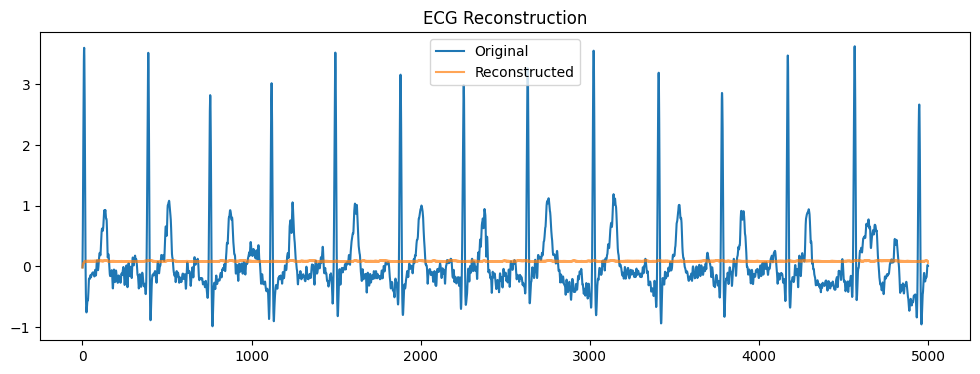

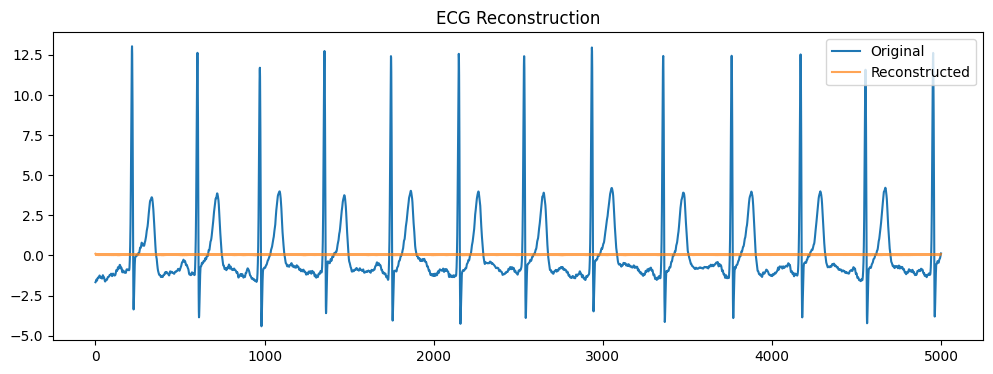

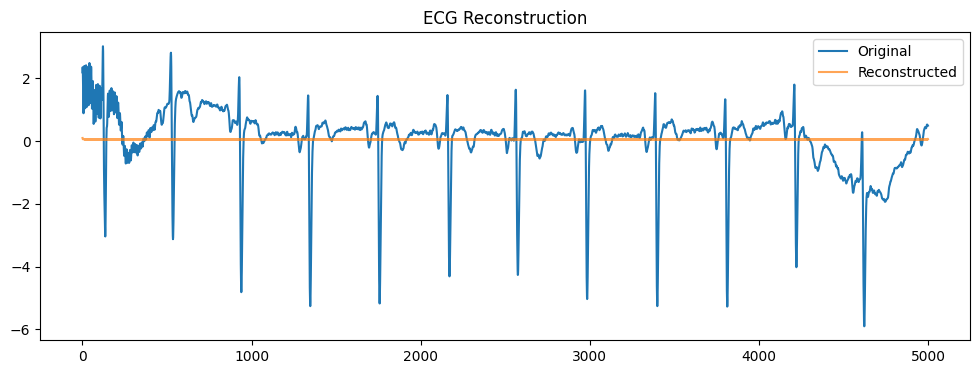

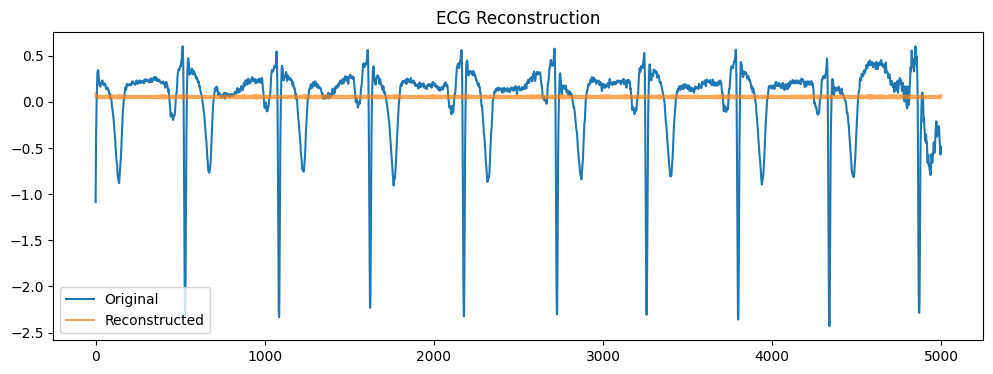

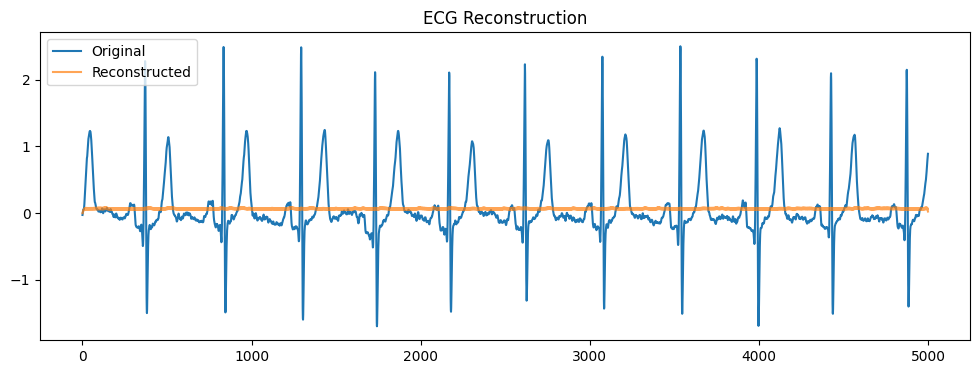

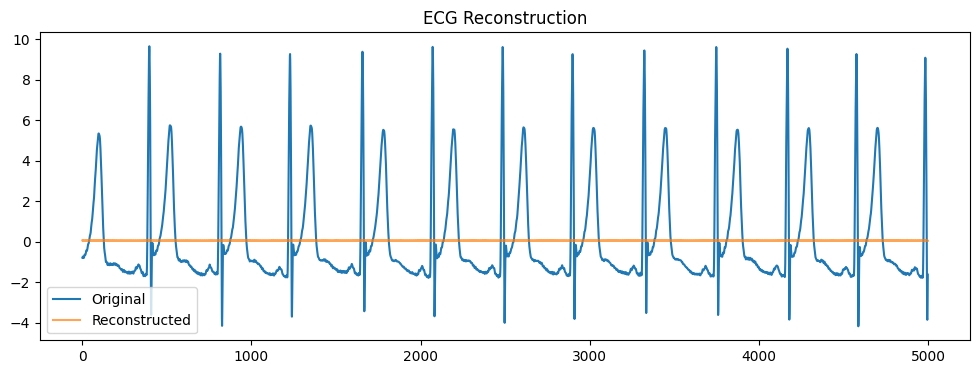

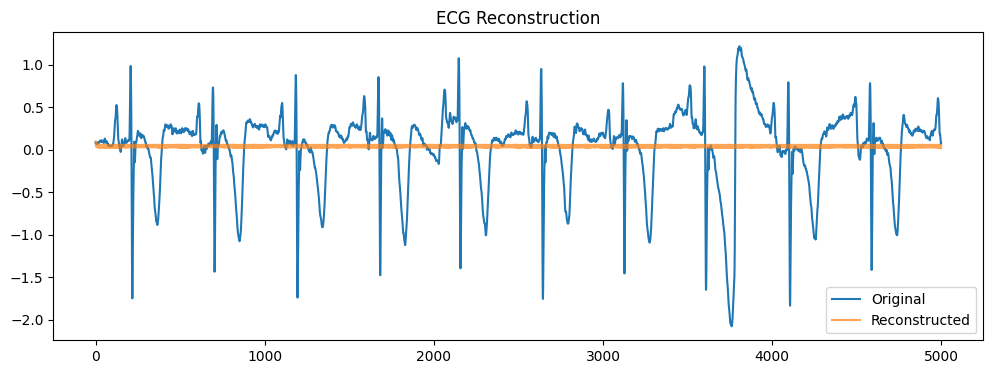

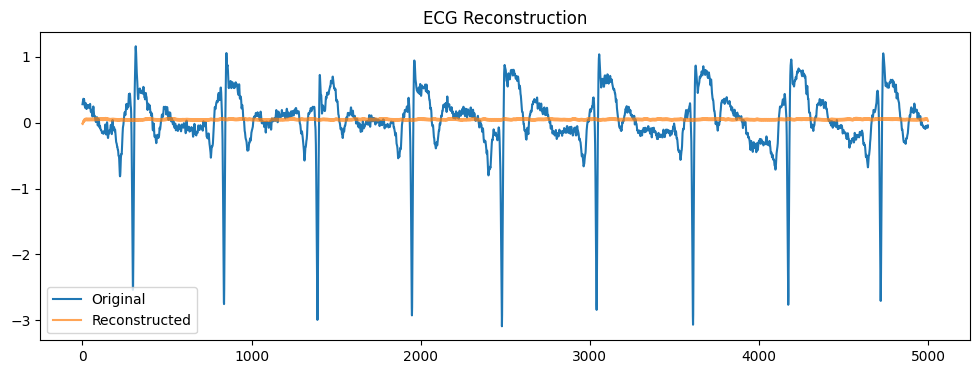

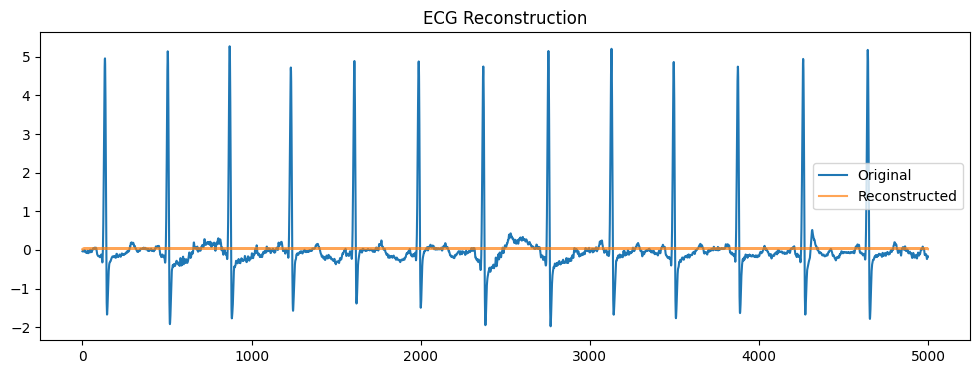

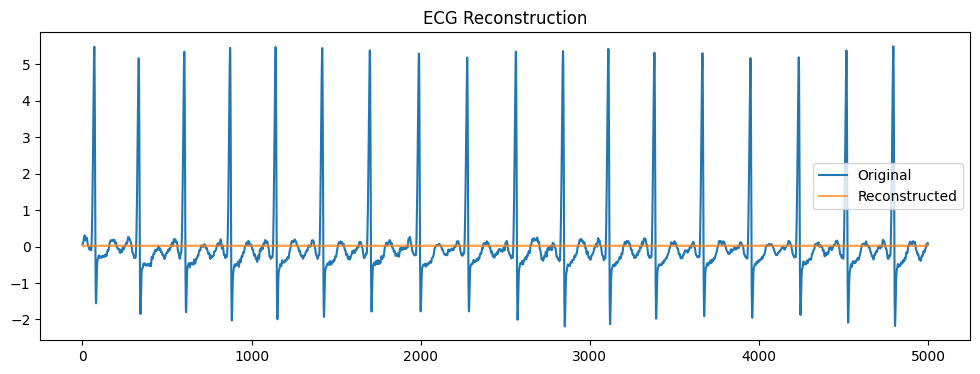

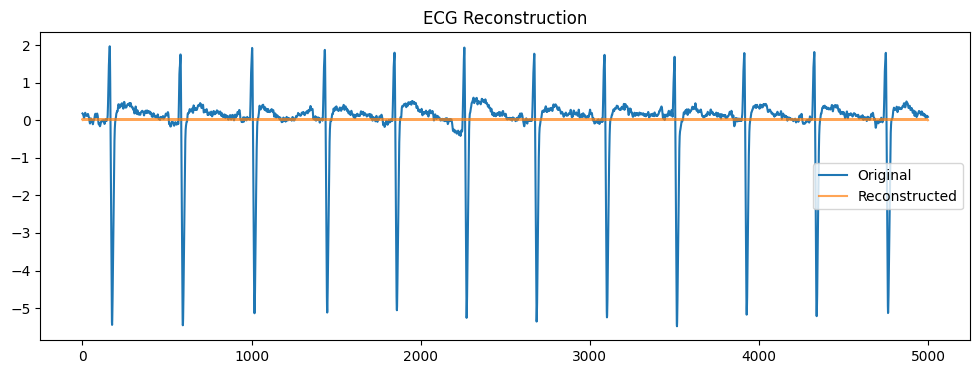

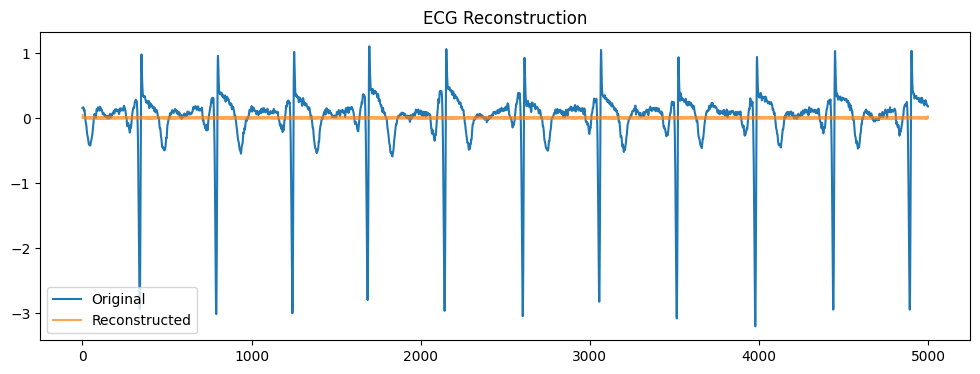

In [88]:
plot_reconstruction(model, test_data, 1)

In [23]:
model.eval()

with torch.no_grad():
    embeddings = model.get_embeddings(test_data).numpy()

In [24]:
embeddings.shape

(29, 1250, 64)

In [25]:
embeddings_avg = embeddings.mean(axis=1)

In [26]:
reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = reducer.fit_transform(embeddings_avg)

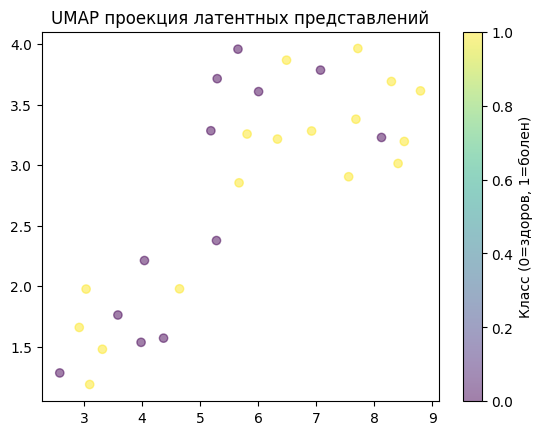

In [30]:
plt.scatter(
    embeddings_2d[:, 0], 
    embeddings_2d[:, 1],
    c=y_test,  # Цвета по меткам
    cmap="viridis",
    alpha=0.5
)
plt.colorbar(label="Класс (0=здоров, 1=болен)")
plt.title("UMAP проекция латентных представлений")
plt.show()

UMAP, average


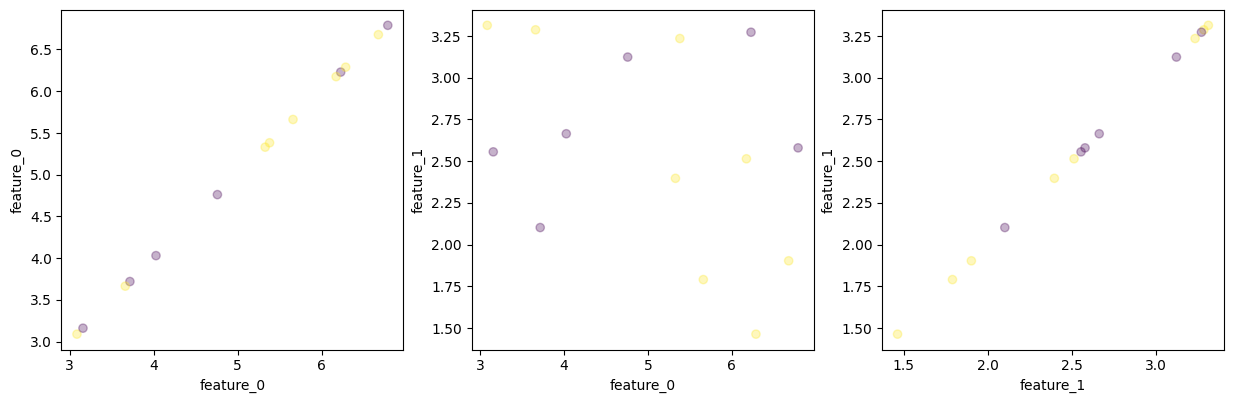

UMAP, flatten


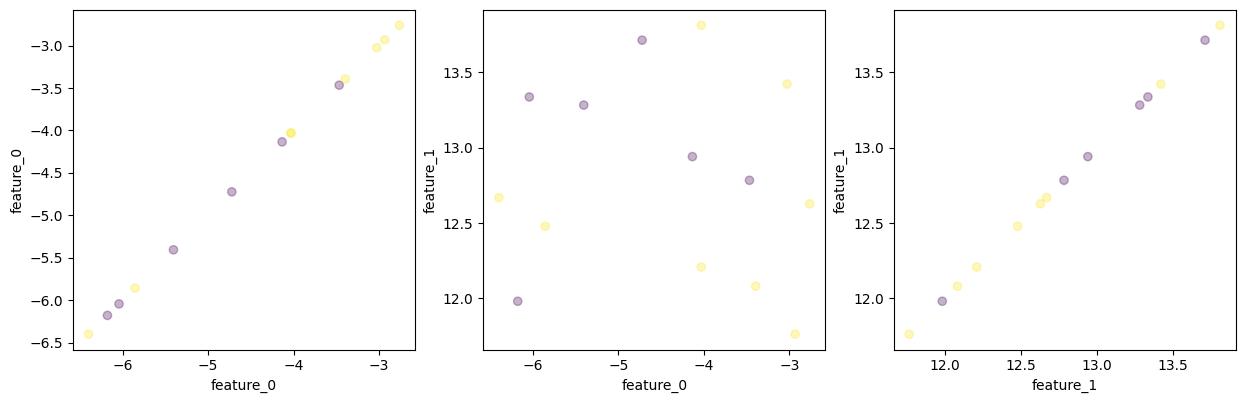

In [25]:
test_data_2 = test_data[0:14]
y_2 = y_test[0:14]

plt.rcParams['figure.figsize'] = [15, 15]

umaper(model, test_data_2, y_2)

In [ ]:
test_data_2 = test_data[0:14]
y_2 = y_test[0:14]

plt.rcParams['figure.figsize'] = [15, 15]

umaper(model, test_data_2, y_2)

In [35]:
signals, labels = load_data('../csv/metadata.csv', 0, 4000, False)
signals, labels = delete_bad_snr_db(signals, labels)

signals_transformed = signal_transform_tensor_12(signals)
labels_transformed = label_transform_tensor(labels)

X = torch.tensor(signals_transformed)
y = torch.tensor(labels_transformed, dtype=torch.float32).reshape((len(labels_transformed), 1))

# Разделение на train/test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Конвертация в тензоры
train_data = torch.FloatTensor(X).to(device)
# test_data = torch.FloatTensor(X_test).to(device)

# train_loader = DataLoader(TensorDataset(train_data, train_data), batch_size=32, shuffle=True)
# test_loader = DataLoader(TensorDataset(test_data, test_data), batch_size=32)

Data loaded successfully.
          Health    number:     2148
          Diseased  number:     1852


num of left: 2999
Label transformed to tensor successfully



UMAP, average


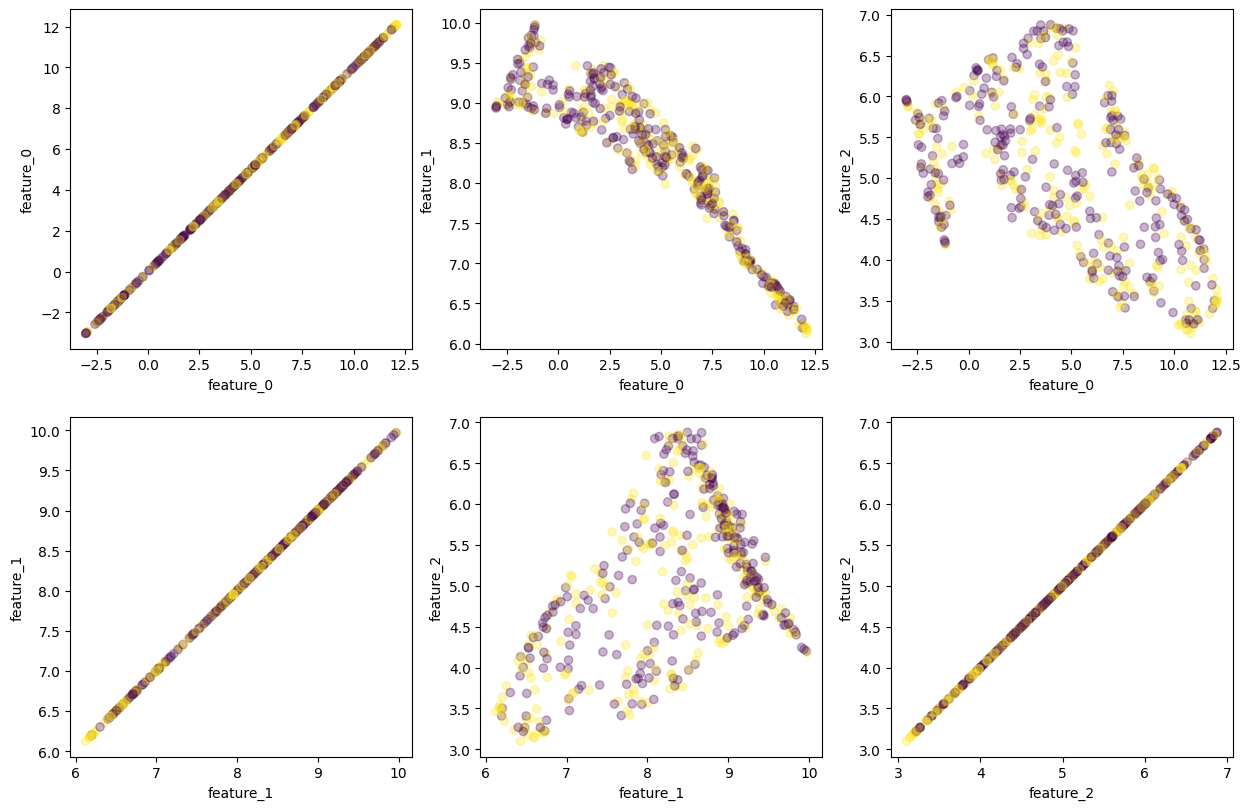

UMAP, flatten


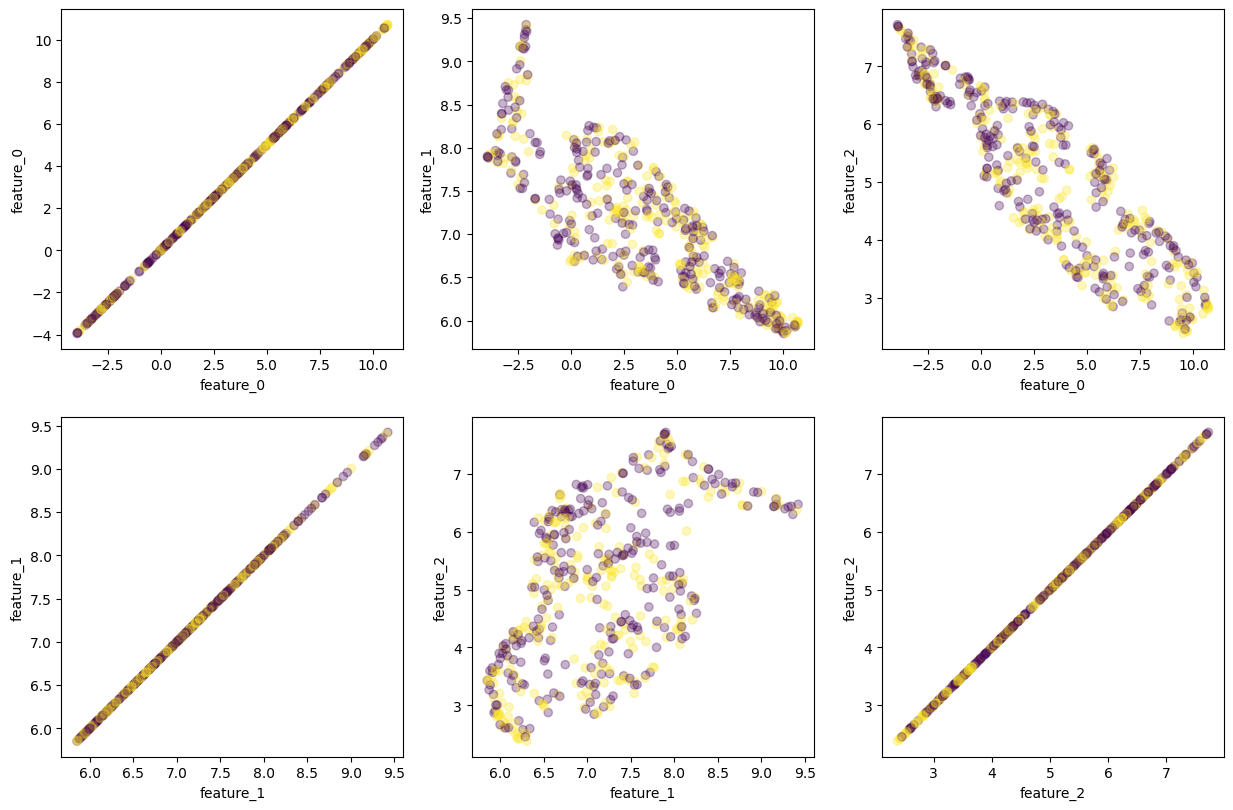

In [38]:
test_data_2 = train_data[0:500]
y_2 = y[0:500]

plt.rcParams['figure.figsize'] = [15, 15]

umaper(model, test_data_2, y_2, 3)

In [41]:
signals, labels, ages, sexs = load_data_age_sex('../csv/metadata.csv', 0, 4000, False)
signals, labels, ages, sexs = delete_bad_snr_db_ages_sexs(signals, labels, ages, sexs)

signals_transformed = signal_transform_tensor_12(signals)
labels_transformed = label_transform_tensor(labels)

X = torch.tensor(signals_transformed)
y = torch.tensor(labels_transformed, dtype=torch.float32).reshape((len(labels_transformed), 1))

# Разделение на train/test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Конвертация в тензоры
train_data = torch.FloatTensor(X).to(device)
# test_data = torch.FloatTensor(X_test).to(device)

# train_loader = DataLoader(TensorDataset(train_data, train_data), batch_size=32, shuffle=True)
# test_loader = DataLoader(TensorDataset(test_data, test_data), batch_size=32)

Data loaded successfully.
          Health    number:     2148
          Diseased  number:     1852


num of left: 2999
Label transformed to tensor successfully



In [42]:
def umaper_ages_sexs(model, x_data, y_data, age_data, sex_data, n_components=2, alpha=0.3):
    model.eval()

    with torch.no_grad():
        embeddings = model.get_embeddings(x_data).numpy()
    
    embeddings_avg = embeddings.mean(axis=1)

    embeddings_avg_ = []

    for i in range(len(age_data)):
        embeddings_avg_.append(embeddings_avg[i].tolist())
        embeddings_avg_[i].append(age_data[i])
        embeddings_avg_[i].append(sex_data[i])
    
    reducer = umap.UMAP(n_components=n_components)
    embeddings_2d = reducer.fit_transform(embeddings_avg_)

    num = [331, 332, 333, 334, 335, 336, 337, 338, 339]
    k = 0

    print("UMAP, average")
    for i in range(n_components):
        for j in range(i, n_components):
            if k >= 9:
                k = 0
                plt.show()
                plt.figure()
            plt.subplot(num[k])

            plt.scatter(
                embeddings_2d[:, i], 
                embeddings_2d[:, j],
                c=y_data,  # Цвета по y_data
                cmap="viridis",
                alpha=alpha
            )
            plt.xlabel(f"feature_{i}")
            plt.ylabel(f"feature_{j}")
            k += 1
    
    if k != 9:
        plt.show()

UMAP, average


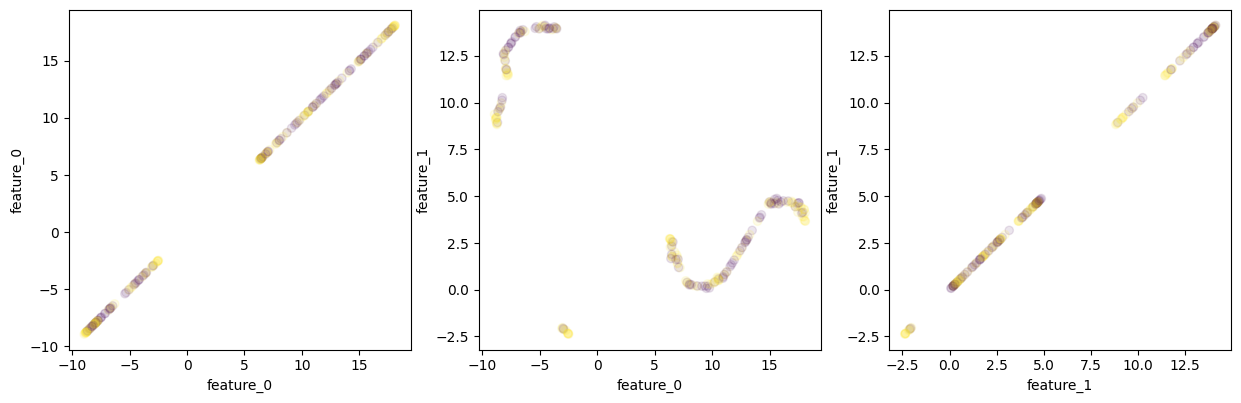

In [45]:
n = 200
w = 1

test_data_2 = train_data[0:n*w]
y_2 = y[0:n*w]
# age_2 = ages[0:14]
# sex_2 = sexs[0:14]

age_2 = []
sex_2 = []

for i in range(n):
    for j in range(w):
        age_2.append(ages[i])
        sex_2.append(sexs[i])

scaler = MinMaxScaler()
age_2 = np.reshape(age_2, (-1, 1))
age_2 = scaler.fit_transform(age_2)
age_2 = np.reshape(age_2, (-1))

plt.rcParams['figure.figsize'] = [15, 15]

umaper_ages_sexs(model, test_data_2, y_2, age_2, sex_2, alpha=0.1)

UMAP, average


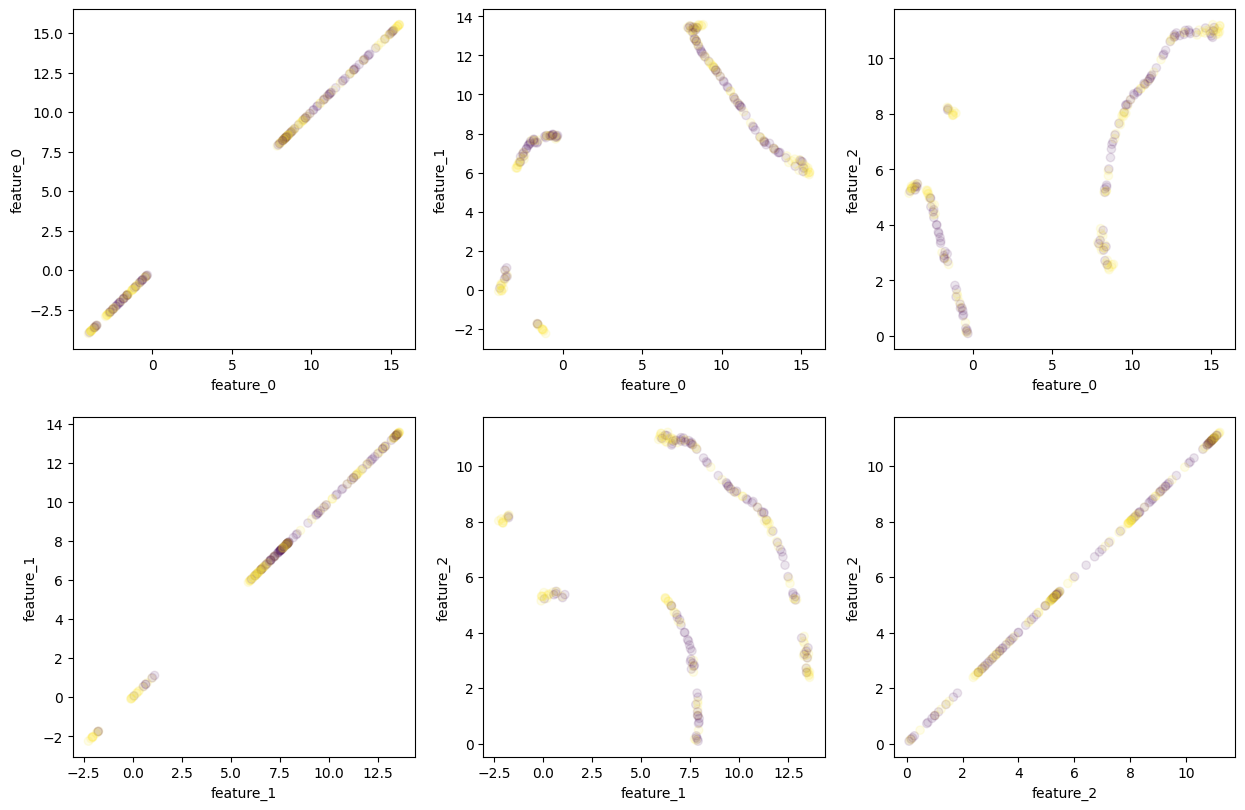

In [46]:
n = 200
w = 1

test_data_2 = train_data[0:n*w]
y_2 = y[0:n*w]
# age_2 = ages[0:14]
# sex_2 = sexs[0:14]

age_2 = []
sex_2 = []

for i in range(n):
    for j in range(w):
        age_2.append(ages[i])
        sex_2.append(sexs[i])

scaler = MinMaxScaler()
age_2 = np.reshape(age_2, (-1, 1))
age_2 = scaler.fit_transform(age_2)
age_2 = np.reshape(age_2, (-1))

plt.rcParams['figure.figsize'] = [15, 15]

umaper_ages_sexs(model, test_data_2, y_2, age_2, sex_2, alpha=0.1, n_components=3)

In [61]:
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
import seaborn as sns

def umaper_ages_sexs_bayes(model, x_data, y_data, age_data, sex_data, n_components=2, alpha=0.3):
    model.eval()

    with torch.no_grad():
        embeddings = model.get_embeddings(x_data).numpy()
    
    embeddings_avg = embeddings.mean(axis=1)

    embeddings_avg_ = []

    for i in range(len(age_data)):
        embeddings_avg_.append(embeddings_avg[i].tolist())
        embeddings_avg_[i].append(age_data[i])
        embeddings_avg_[i].append(sex_data[i])
    
    reducer = umap.UMAP(n_components=n_components)
    embeddings_2d = reducer.fit_transform(embeddings_avg_)

    bayes_model = GaussianNB()
    calibrated_model = CalibratedClassifierCV(bayes_model, method='isotonic', cv=5)
    calibrated_model.fit(embeddings_2d, y_data)

    # Предсказание вероятностей для всех точек
    probabilities = calibrated_model.predict_proba(embeddings_2d)

    # Визуализация вероятностного распределения
    plt.figure(figsize=(15, 6))

    # 1. Визуализация истинных меток
    plt.subplot(131)
    sns.scatterplot(
        x=embeddings_2d[:, 0], y=embeddings_2d[:, 1],
        hue=y_data.flatten(), palette={0: "red", 1: "green"},
        alpha=0.2
    )
    plt.title("Истинные метки классов")

    # 2. Визуализация предсказанных вероятностей класса 1
    plt.subplot(132)
    scatter = plt.scatter(
        embeddings_2d[:, 0], embeddings_2d[:, 1],
        c=probabilities[:, 1], cmap='coolwarm',
        alpha=0.2, vmin=0, vmax=1
    )
    plt.colorbar(scatter, label='Вероятность класса 1 (больные)')
    plt.title("Байесовские вероятности классов")

    # 3. Визуализация неопределенности (энтропия распределения)
    entropy = -np.sum(probabilities * np.log(probabilities + 1e-10), axis=1)
    plt.subplot(133)
    scatter = plt.scatter(
        embeddings_2d[:, 0], embeddings_2d[:, 1],
        c=entropy, cmap='viridis',
        alpha=0.2
    )
    plt.colorbar(scatter, label='Энтропия (неопределенность)')
    plt.title("Неопределенность классификации")

    plt.suptitle("Байесовское вероятностное распределение на UMAP-представлении")
    plt.tight_layout()
    plt.show()

    # Оценка качества модели
    test_probs = calibrated_model.predict_proba(embeddings_2d)
    test_preds = np.argmax(test_probs, axis=1)
    test_accuracy = np.mean(test_preds == y_data)
    print(f"\nТочность на тестовом наборе: {test_accuracy:.4f}")

    # Построение вероятностной поверхности
    def plot_probability_surface(model, X, y):
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                            np.linspace(y_min, y_max, 100))
        
        Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z = Z.reshape(xx.shape)
        
        plt.figure(figsize=(10, 8))
        contour = plt.contourf(xx, yy, Z, levels=20, cmap='coolwarm', alpha=0.8)
        plt.colorbar(contour, label='Вероятность класса 1')
        sns.scatterplot(
            x=X[:, 0], y=X[:, 1],
            hue=y.flatten(), palette={0: "red", 1: "green"},
            edgecolor='k', alpha=0.2
        )
        plt.title("Вероятностная поверхность байесовского классификатора")
        plt.xlabel("UMAP 1")
        plt.ylabel("UMAP 2")
        plt.show()

    plot_probability_surface(calibrated_model, embeddings_2d, y_data)

    return calibrated_model

In [ ]:
n = 2000
w = 1

test_data_2 = train_data[0:n*w]
y_2 = y[0:n*w]

age_2 = []
sex_2 = []

for i in range(n):
    for j in range(w):
        age_2.append(ages[i])
        sex_2.append(sexs[i])

scaler = MinMaxScaler()
age_2 = np.reshape(age_2, (-1, 1))
age_2 = scaler.fit_transform(age_2)
age_2 = np.reshape(age_2, (-1))

umaper_ages_sexs_bayes(model, test_data_2, y_2, age_2, sex_2)